###### working directory G:\My Drive\Data\CA Congressional District_Compilation\Notebooks

In [1]:
# load libraries

from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import shapely.geometry as sg
import folium
import geojson
import fiona
import matplotlib as mpl
import pysal
import mapclassify

import matplotlib.cm as cm, matplotlib.font_manager as fm
from datetime import datetime as dt
from shapely.geometry import Polygon
from geopy.distance import great_circle
from geopandas import GeoDataFrame
import descartes
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline


In [2]:
df1 = pd.read_csv(r'G:\My Drive\Data\Race Eth ACS 2017\Geo_Files\race_ethn_w_predom_export.csv')
df1.head(2)

,GEOID,Total,Estimate White,Estimate Latino,Estimate POC,Estimate Black,Estimate Asian,Estimate Other Race,White,Latino,Black,Asian,Other_Race,POC,Census Tract,County,predominant_race,predominant_race_pct,District_50,whites_below_average,poc_abv_average,white_poc
0,6065043216,6359,3356,1792,3003,417,600,194,52.775594,28.180532,6.557635,9.435446,3.050794,47.224406,CT 432.16,Riverside,White,52.775594,Demographics,1,1,2
1,6065043218,5415,3561,1497,1854,74,211,72,65.761773,27.645429,1.366574,3.896584,1.329640,34.238227,CT 432.18,Riverside,White,65.761773,Demographics,0,0,0


In [3]:
# selecting columns from race dataset
cols = ['GEOID','white_poc', 'White', 'Latino']
df1 = df1[cols]
df1.head(2)

,GEOID,white_poc,White,Latino
0,6065043216,2,52.775594,28.180532
1,6065043218,0,65.761773,27.645429


In [4]:
# read in density file
df2 = pd.read_csv(r'G:\My Drive\Data\Density 2017\Data_Exports\density.csv')

In [5]:
cols = ['GEOID','density_abv_average']
df2 = df2[cols]
df2.head(2)

,GEOID,density_abv_average
0,6065043216,0
1,6065043218,0


In [6]:
#read in eligible voter file
df3 = pd.read_csv(r'G:\My Drive\Data\Voting Age Data Census 2018 5yr\Data_Exports\eligible_voters_score.csv')
df3=df3.drop(['Unnamed: 0' ], axis = 1) 

In [7]:
cols = ['GEOID', 'pct_18_29_abv_ave', 'total_over_18_abv_ave']
df3 = df3[cols]
df3.head(2)

,GEOID,pct_18_29_abv_ave,total_over_18_abv_ave
0,6065043216,1,1
1,6065043218,1,0


In [8]:
#read in precinct data
df4 = pd.read_csv(r'G:\My Drive\Data\Precinct Data CA 2016\Geo_Files\precinct_data_2016_by_ct_export_submitted.csv')
df4.head(2)

,GEOID,geometry,democratic,republican,total_votes_by_ct,dem_pct_vote
0,6065051200,"MULTIPOLYGON (((-117.14876 33.472902, -117.149...",224.0,242.0,466.0,48.1
1,6073020029,"POLYGON ((-117.189032 33.148124, -117.188948 3...",279.0,223.0,502.0,55.6


In [9]:
cols = ['GEOID', 'dem_pct_vote']
df4 = df4[cols]
df4.head(2)

,GEOID,dem_pct_vote
0,6065051200,48.1
1,6073020029,55.6


In [10]:
merge1 = pd.merge(df3, df2, on='GEOID', how='inner')
merge1.head(2)

,GEOID,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average
0,6065043216,1,1,0
1,6065043218,1,0,0


In [11]:
merged = pd.merge(df1, merge1, on='GEOID', how='inner')
merged.head(2)

,GEOID,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average
0,6065043216,2,52.775594,28.180532,1,1,0
1,6065043218,0,65.761773,27.645429,1,0,0


In [12]:
final_df = pd.merge(df4, merged, on='GEOID', how='inner')

In [13]:
final_df.head(2)

,GEOID,dem_pct_vote,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average
0,6065051200,48.1,2,43.703148,43.778111,1,0,0
1,6073020029,55.6,2,23.538541,70.994999,1,0,0


In [14]:
final_df['score'] = final_df['white_poc'] + final_df['pct_18_29_abv_ave'] + final_df['total_over_18_abv_ave'] + final_df['density_abv_average']

In [15]:
final_df['score_pct'] = final_df['score'] / 5 *100
final_df.head(2)

,GEOID,dem_pct_vote,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average,score,score_pct
0,6065051200,48.1,2,43.703148,43.778111,1,0,0,3,60.0
1,6073020029,55.6,2,23.538541,70.994999,1,0,0,3,60.0


In [16]:
# read in data with geometry
geo = gpd.read_file(r'G:\My Drive\Data\Race Eth ACS 2017\Geo_Files\CA_congress.geojson')
geo.head(2)

,GEOID,geometry
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
1,6065049600,"POLYGON ((-117.16311 33.52238, -117.16311 33.5..."


In [17]:
# Joining data to geo
final_df2 = pd.merge(geo, final_df, on='GEOID', how='inner')
final_df2.head(2)

,GEOID,geometry,dem_pct_vote,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average,score,score_pct
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",48.1,2,43.703148,43.778111,1,0,0,3,60.0
1,6073020029,"POLYGON ((-117.18903 33.14812, -117.18895 33.1...",55.6,2,23.538541,70.994999,1,0,0,3,60.0


In [18]:
final_df2.describe()

,GEOID,dem_pct_vote,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average,score,score_pct
count,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,6.072126e+09,38.344755,0.937063,57.137092,30.517608,0.405594,0.405594,0.356643,2.104895,42.097902
std,2.522788e+06,11.733068,1.001525,18.216504,18.139680,0.492733,0.492733,0.480692,1.630317,32.606341
min,6.065043e+09,11.800000,0.000000,3.947660,4.698206,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.073017e+09,30.850000,0.000000,48.161508,18.614040,0.000000,0.000000,0.000000,1.000000,20.000000
50%,6.073019e+09,35.800000,0.000000,60.919081,26.052019,0.000000,0.000000,0.000000,2.000000,40.000000
75%,6.073020e+09,43.850000,2.000000,70.914265,37.785553,1.000000,1.000000,1.000000,4.000000,80.000000
max,6.073021e+09,100.000000,2.000000,87.326990,93.501885,1.000000,1.000000,1.000000,5.000000,100.000000


In [19]:
# final_df2 = final_df2.loc[final_df2['score_pct'] > 41]
# final_df2

In [20]:
type(final_df2)

geopandas.geodataframe.GeoDataFrame

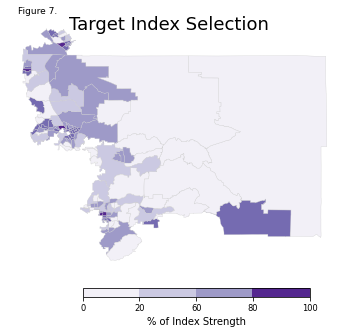

In [21]:
# variable = 'score_pct'
# final_df2

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis('off')

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', [ '#f2f0f7', '#cbc9e2', '#9e9ac8', '#756bb1', '#54278f'], 5)

final_df2.plot(cmap=cmap, scheme='quantiles', ax=ax, column='score_pct', linewidth=0.3, edgecolor='0.8')

# The tick marks we want for our map.  We'll pull these directly from the mapclassify code.
bounds = list(mapclassify.Quantiles(final_df2['score_pct'], k=5).bins)

# This controls how the colors are scaled using the above bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

# This sets where the colorbar goes and its size
cbax = fig.add_axes([.3, .15, 0.525, 0.02])

cb2 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, ticks=bounds, orientation='horizontal')

cb2.set_label(r'% of Index Strength')
cb2.ax.xaxis.set_label_position('bottom')
cb2.ax.xaxis.label.set_multialignment('left')
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

# add a title
#fig.suptitle('What percentage of votes are Democrats winning?', x=.3, y=1, fontsize=18, fontweight= 3)
fig.suptitle('Target Index Selection', x=.5, y=.8, fontsize=18, fontweight= 3)


# add a footnote
plt.figtext(.15, .8, r'Figure 7.' , ha='left', va='bottom', fontsize=9)

#this will save the figure as a high-res png. you can also save as svg
fig.savefig(r'G:\My Drive\Data\CA Congressional District_Compilation\Graphs\GoogleDoc_Target_Score.png', 
            bbox_inches='tight',pad_inches=0.1, dpi=200)

In [22]:
# selecting rows based on condition 
final_df2 = final_df2.loc[final_df2['score_pct'] > 41]
final_df2.head(2)

,GEOID,geometry,dem_pct_vote,white_poc,White,Latino,pct_18_29_abv_ave,total_over_18_abv_ave,density_abv_average,score,score_pct
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",48.1,2,43.703148,43.778111,1,0,0,3,60.0
1,6073020029,"POLYGON ((-117.18903 33.14812, -117.18895 33.1...",55.6,2,23.538541,70.994999,1,0,0,3,60.0


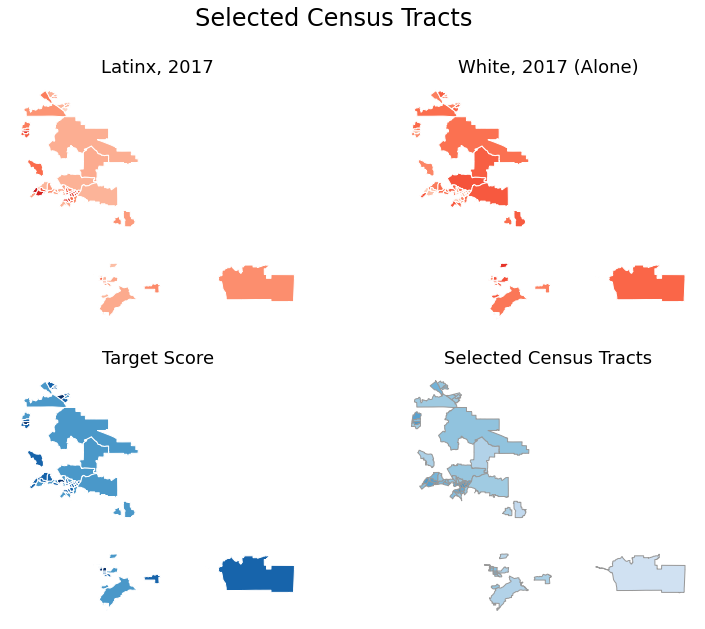

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

variable  = 'Latino'
variable2 = 'White'
variable3 =  'score_pct'
variable4 = 'dem_pct_vote'


side_length = 10
fig, axes = plt.subplots(2, 2, figsize=(side_length * 2.1, side_length))
fig.subplots_adjust(hspace=.15, wspace=-.5)

#final_df2.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8')

# 1st subplot /// Latino
# assume data is in a list data1
ax = final_df2.plot(column=variable, ax=axes.flat[0], cmap='Reds', edgecolor='white', k=5, vmin=0, vmax=100)
ax.set_axis_off()
ax.set_aspect('equal')

ax.set_title('Latinx, 2017', \
              fontdict={'fontsize': '18',
                        'fontweight' : '3'})


# 2nd subplot  /// White
ax = final_df2.plot(column=variable2, ax=axes.flat[1], cmap='Reds', edgecolor='white' , k=5, vmin=0, vmax=100)
ax.set_axis_off()
ax.set_aspect('equal')

ax.set_title('White, 2017 (Alone)', \
              fontdict={'fontsize': '18',
                        'fontweight' : '3'})

# 3 subplot /// score
# assume data is in a list data1
ax = final_df2.plot(column=variable3, ax=axes.flat[2], cmap='Blues', edgecolor='white' , k=5, vmin=0, vmax=100)
ax.set_axis_off()
ax.set_aspect('equal')

ax.set_title('Target Score', \
              fontdict={'fontsize': '18',
                        'fontweight' : '3'})

# 4 subplot  /// pct of dem votes
ax = final_df2.plot(column=variable4, ax=axes.flat[3], cmap='Blues', edgecolor='.6' , k=5, vmin=0, vmax=100)
ax.set_axis_off()
ax.set_aspect('equal')

ax.set_title('Selected Census Tracts', \
              fontdict={'fontsize': '18',
                        'fontweight' : '3'})

# # cax = fig.add_axes([0.9, 0.17, 0.02, 0.65])
# # # Add single colorbar
# cax = fig.add_axes([.8, 0.17, 0.02, 0.65])
# sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100))
# sm._A = []
# cbar = fig.colorbar(sm, cax=cax)
# cbar.ax.set_title('% Race/Ethnicity')

fig.suptitle('Selected Census Tracts', fontsize=24, fontweight= 3)
            
             # or plt.suptitle('Main title')

fig.savefig(r'G:\My Drive\Data\CA Congressional District_Compilation\Graphs\Selected_Four_maps_comparison.png', bbox_inches='tight',pad_inches=0.1, dpi=200)

#fig.savefig('myFig.pdf', bbox_inches='tight', pad_inches=0.1)